# 1  Mod 4 Project: Natural Language Processing (NLP) -  Working Copy

### Improving online conversation: Use of NLP analysis to build a multi-headed model capable of detecting different types of online discussion toxicity like threats, obscenity, insults, and identity-based hate.



   Student name: Andi Osika  
 * Student pace: part time
 * Scheduled project review date/time: TBD
 * Instructor name: James Irving, PhD
 * Blog post URL: 

## Project Quick Links:
**Link** | **Description**
--| --|
[Background](#Background:) | Details around the subject, datasource and objective
[Preprocessing](#Preprocessing:) | Steps taken to prepare data for modeling and evaluation
[Main Dataset](#Main-Dataset:) | The dataset in it's final form used for the predictive modeling results described in the [Conclusion](#Conclusion:)  section
[Modeling](#Modeling:) | Various iterations of predictive classification modeling including Decision Trees, Random Forest and XGBoost
[Best Model](#BEST-MODEL:-Manually-Tuned-Random-Forest) |Random Forest Classification Model including [Visualizations]() Confusion Matrix, ROC Curve, Feature Importance by Rank, Correlations
    [Conclusion](#Conclusion:) | Summation of outcomes from modeling

## Background:

Freedom of speech is a right.  Digital platforms facilitate conversations but struggle to efficiently do so in a way that facilitates this freedom in a way that minimizes the threat of online abuse and harrasment that can come with the 'anonymity effect' of a virtual climate.   

This dataset is provided by [Conversation AI ](https://conversationai.github.io/) is a collaborative research effort exploring ML as a tool for better discussions online.  The source is a dataset of comments from Wikipedia’s talk page edits. 

A classification list of 159,571 samples is provided of Wikipedia comments which have been labeled by human raters for toxic behavior. 

>The types of toxicity are:
* toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

The goal of this notebook is to build a model to help identify the various levels of toxicity with 

## Preprocessing:

### Importing the appropriate packages:

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
!pip install gensim
import functions as fn
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

2022-04-09 18:03:26.159143+03:00
[i] Timer started at04/09/22 - 06:03 PM
[i] Timer ended at 04/09/22 - 06:03 PM
- Total time = 0:00:00.001007


### Data Import: Trainging and Testing DataSets

#### Test

In [2]:
test = pd.read_csv('/home/admin/NLP-to-identify-toxic-or-abusive-language-for-online-conversation-using-Keras-Deep-Learning-Models/test.csv.zip', index_col='id')
test.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [3]:
X_test = test['comment_text']

In [4]:
y_test = pd.read_csv('/home/admin/NLP-to-identify-toxic-or-abusive-language-for-online-conversation-using-Keras-Deep-Learning-Models/test_labels.csv.zip', index_col='id')


In [5]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [6]:
len(y_test)

153164

In [7]:
y_test = y_test[y_test.sum(axis=1)!=-6]
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0001ea8717f6de06,0,0,0,0,0,0
000247e83dcc1211,0,0,0,0,0,0
0002f87b16116a7f,0,0,0,0,0,0
0003e1cccfd5a40a,0,0,0,0,0,0
00059ace3e3e9a53,0,0,0,0,0,0


In [8]:
len(y_test)

63978

In [9]:
val_counts_test = y_test.apply(pd.Series.value_counts)
val_counts_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,57888,63611,60287,63767,60551,63266
1,6090,367,3691,211,3427,712


<AxesSubplot:>

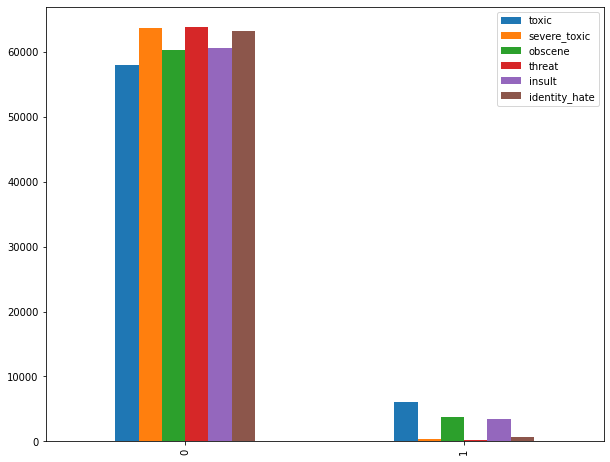

In [10]:

val_counts_test.head(2).plot(kind='bar',figsize=(10,8))

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/55975

#### Train

In [11]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
X = train['comment_text']

In [13]:
target_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[target_classes]

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,108205,118469,113380,119311,113763,118630
1,11473,1209,6298,367,5915,1048


In [17]:
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000,119678.000000
mean,0.095866,0.010102,0.052625,0.003067,0.049424,0.008757
std,0.294408,0.100001,0.223284,0.055292,0.216753,0.093168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# check for any 'null' comment
no_comment = X_train.isnull().value_counts()
len(no_comment)

1

In [19]:
X_train.dropna(inplace=True)

<AxesSubplot:>

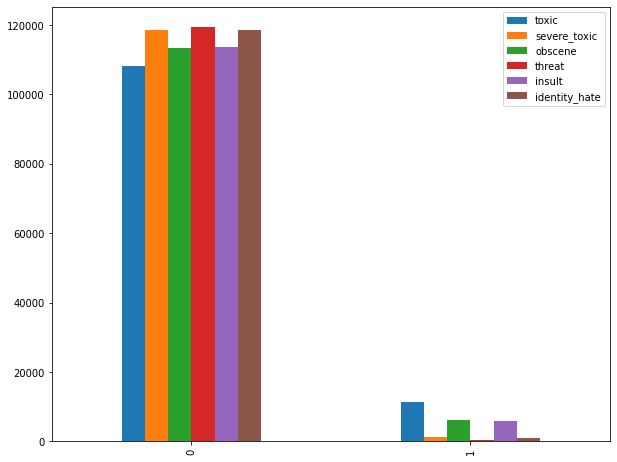

In [20]:
val_counts = y_train.apply(pd.Series.value_counts)
val_counts.head(2).plot(kind='bar',figsize=(10,8))

In [21]:
##develop the viz above to illustrate

In [22]:
value_counts_train = round(val_counts.head(2).T)
value_counts_train

,0,1
toxic,108205,11473
severe_toxic,118469,1209
obscene,113380,6298
threat,119311,367
insult,113763,5915
identity_hate,118630,1048


<AxesSubplot:>

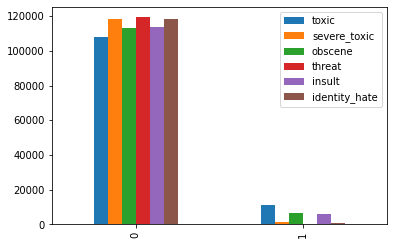

In [23]:
value_counts_train.T.plot(kind='bar')

In [24]:
unlabelled_in_all = y_train[(y_train['toxic']!=1) & (y_train['severe_toxic']!=1) & (y_train['obscene']!=1) & 
                            (y_train['threat']!=1) & (y_train['insult']!=1) & (y_train['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', round(len(unlabelled_in_all)/len(train)*100))

Percentage of unlabelled comments is  67


In [25]:
#Total rows in train
print('Total rows in X_train is {}'.format(len(X_train)))

Total rows in X_train is 119678


<AxesSubplot:>

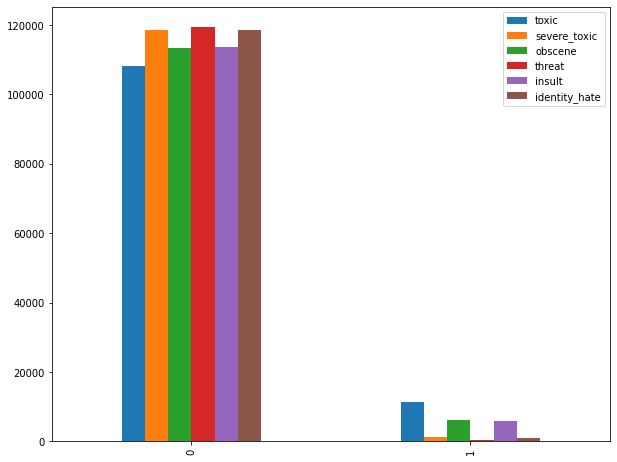

In [26]:
val_counts.head(2).plot(kind='bar',figsize=(10,8))

In [27]:
y_train[y_train[target_classes].sum(axis=1)>0]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
17872,1,0,0,1,0,0
53441,1,0,1,0,1,0
32831,1,0,0,0,0,0
802,1,0,1,1,1,0
62911,1,0,1,0,1,0
...,...,...,...,...,...,...
105964,1,0,0,0,0,0
116097,1,0,1,0,1,0
152449,1,0,0,0,0,0
106703,1,0,0,0,0,0


You can see here that some labels can be assigned to more than one class

#### The Text Data:

An initial look will examine frequency distributions

In [28]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

# It is generally a good idea to also remove punctuation

# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

In [29]:
text = str(list(X_train))

### Tokenizing initial set of text corpus to develop stopword list:
(Takes 2 Min)

In [30]:
timer = fn.Timer()

timer.start()
tokens = word_tokenize(text)
timer.stop()

[i] Timer started at04/09/22 - 06:03 PM
[i] Timer ended at 04/09/22 - 06:04 PM
- Total time = 0:00:47.574720


In [31]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')

#remove punctuation
stopwords_list += list(string.punctuation)
##adding adhoc all strings that don't appear to contribute, added 'article, page and wikipedia' iteratively as 
##these are parts of most comment strings
stopwords_list += ("''","``", "'s", "\\n\\n" , '...', 'i\\','\\n',
                   '•', "i", 'the', "'m", 'i\\', "'ve", "don\\'t",
                  "'re", "\\n\\ni", "it\\", "'ll", 'you\\', "'d", "n't",
                  '’', 'article', 'page', 'wikipedia') 
                   

In [32]:
timer = fn.Timer()
timer.start()
stopped_tokens = [w.lower() for w in tokens if w.lower() not in stopwords_list]
timer.stop()

[i] Timer started at04/09/22 - 06:04 PM
[i] Timer ended at 04/09/22 - 06:04 PM
- Total time = 0:00:15.739569


In [33]:
len(stopped_tokens)

4119825

In [34]:
from nltk import FreqDist
freqdist = FreqDist(stopped_tokens)
most_common_stopped = freqdist.most_common(200)
most_common_stopped

[('talk', 25419),
 ('would', 22236),
 ('like', 20931),
 ('one', 20692),
 ('please', 18587),
 ('see', 15590),
 ('think', 14974),
 ('also', 14485),
 ('know', 14326),
 ('people', 13359),
 ('edit', 13178),
 ('articles', 12026),
 ('use', 11868),
 ('may', 11543),
 ('time', 11323),
 ('even', 10032),
 ('get', 9863),
 ('make', 9587),
 ('user', 9180),
 ('good', 9006),
 ('could', 8918),
 ('information', 8914),
 ('want', 8654),
 ('way', 8216),
 ('sources', 8126),
 ('name', 8114),
 ('deletion', 7852),
 ('new', 7706),
 ('wp', 7646),
 ('first', 7611),
 ('need', 7598),
 ('source', 7581),
 ('well', 7567),
 ('say', 7552),
 ('editing', 7527),
 ('help', 7438),
 ('pages', 7379),
 ('section', 7351),
 ('edits', 7342),
 ('made', 7204),
 ('image', 7201),
 ('thanks', 7126),
 ('go', 7033),
 ('much', 7013),
 ('many', 6933),
 ('really', 6914),
 ('used', 6895),
 ('find', 6702),
 ('discussion', 6640),
 ('deleted', 6449),
 ('work', 6441),
 ('point', 6225),
 ('since', 6134),
 ('right', 6121),
 ('add', 6034),
 ('look',

In [54]:
# model = Word2Vec(text, size=100, window=5, min_count=1, workers=4)

In [36]:
def clean_comment(comment):
    '''Lemmatizes, removes capitalization, punctuation and 'stopwords' from the lemmatized tokens,
    returns data in the dataframe for modeling in a "clean" state
    
    comment - a text string'''
    from nltk.corpus import stopwords
    import string
    #splitting sentences into tokens
    tokens = comment.split()
    
    #instantiating Lemmatizer and lemmatizing words
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    stopwords_list = stopwords.words('english')
    stopwords_list += ("''","``", ".", 'app', 'apps', 'ca',"--", 'wa', 'ha', 'doe', 'wo', 'u') 

    #remove punctuation, capitalization, and stopwords
    stopwords_list += list(string.punctuation)
    stopped_tokens = [w.lower() for w in lemma_tokens if w.lower() not in stopwords_list]
    
    return ' '.join(stopped_tokens)

In [37]:
X_train.apply(clean_comment)

39321     thanks visiting nice get kind word back. anecd...
54865     dubious a-historical propagandistic original r...
13929     added picture ""question"", still mr. mrs. smi...
2241      november 24 regard zangief edit making, could ...
58775     "==refs== please read wp:medrs. suitable sourc...
                                ...                        
15025     gosh feeling really stupid right now! seriousl...
58178     file:2008 main page redesign proposal kollisio...
10194     yes, faggot!!!! bitch ass motherfucker!!!!! ye...
50463     section cross-dominance? cross-dominant, meani...
114893    "== violins == hello again, voce! you? wonderi...
Name: comment_text, Length: 119678, dtype: object

In [38]:
X_train.head()

39321    "\n\n Thanks for Visiting \n\nNice to get a ki...
54865    "\nIt was dubious a-historical propagandistic ...
13929    "  I added a picture of him that is ""question...
2241     "\n\nNovember 24\n\nWith regard to the Zangief...
58775    "==Refs==\nPlease read WP:MEDRS. This is not a...
Name: comment_text, dtype: object

## Modeling:

In [55]:
!pip install keras --upgrade
!pip install tensorflow --upgrade
!pip install numpy --upgrade
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
#https://github.com/learn-co-students/dsc-classification-with-word-embeddings-codealong-online-ds-pt-100719
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence


TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

I had the same problem and solved it using TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10)
(In this case, I ignore terms that have a document frequency strictly lower than 10)

In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
#try texts_to_matrix
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
comments = [len(comment) for comment in list_tokenized_train]

In [ ]:
plt.hist(comments,bins = np.arange(0,500,10))
plt.axvline(x=400, color='g', ls=':')
plt.title('Comment Length')
plt.show()


In [ ]:
#Average comment block is ~ 30 will capture the majority with 400

In [ ]:
maxlen = 400
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
X_t.shape[1]

In [ ]:
type(X_t)

### Vanilla Neural Network: Keras 

In [ ]:
import random

In [ ]:
random.seed(0)

In [ ]:
van_model = Sequential()

In [ ]:
van_model.add(Dense(10, activation='relu', input_shape=(X_t.shape[1],) ))
van_model.add(Dense(6, activation='sigmoid'))

In [ ]:
van_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
van_history = van_model.fit(X_t, y_train, epochs=10,
                            batch_size=200,
                            validation_split=.2)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = van_history.history['accuracy']
val_acc = van_history.history['val_accuracy']
loss = van_history.history['loss']
val_loss = van_history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
def plot_loss_acc(history):
    import matplotlib.pyplot as plt
    %matplotlib inline 

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) +1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, color='g' , label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    

In [ ]:
plot_loss_acc(van_history)

#### Vanilla Neural Network Observations:

Initialized a very small and shallow 'vanilla' model to observe convergence trends and behavior.  Zero response from validation data and model overtrains by second epoch.

### RNN: LSTM_60_50_6

Implementing LSTM and dropout to see if there's improvement.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=3), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
rnn = Sequential()
embedding_size = 128

rnn.add(Embedding(max_features, embedding_size, input_length=X_t.shape[1] ))
#adding LSTM layer to help 'forget' then pooling
rnn.add(LSTM(60, return_sequences))

In [ ]:
rnn.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
            

In [ ]:
rnn.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=3), 
                  ModelCheckpoint(filepath='best_model.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True)]

In [ ]:
## WARNING ⏰ 50 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn.fit(X_t, y_train, epochs=10, 
                  callbacks=early_stopping,
                  batch_size=200, validation_split=0.2)
timer = timer.stop()

In [ ]:
plot_loss_acc(history)

In [ ]:
y_h_train_probs = rnn.predict(X_t)

In [ ]:
y_hat_test_proba = rnn.predict(X_te)
y_hat_test_proba[1]

In [ ]:
y_preds = pd.DataFrame(np.round(y_hat_test_proba), columns=target_classes)

In [ ]:
y_preds_train = pd.DataFrame(np.round(y_h_train_probs), columns=target_classes)

In [ ]:
y_preds

In [ ]:
y_preds.shape

In [ ]:
y_test.shape

In [ ]:
val_counts_y_preds = y_preds.apply(pd.Series.value_counts)
val_counts

In [ ]:
type(y_preds)


In [ ]:
type(y_test)

In [ ]:
y_train.shape[1]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Training Data Outcomes:

In [ ]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

In [ ]:
for i in range(0,y_train.shape[1]):
    y_i_hat = y_preds.iloc[:,i]
    y_i = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i, y_i_hat))

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_test.head()

In [ ]:
y_test[]

In [ ]:
confusion_matrix(y_hat_test.round(),y_test, normalize=False)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) +1)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc,color='g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, color='g' , label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### RNN_LSTM_tiny_25_20_6

In [ ]:
rnn_tiny = Sequential()
embedding_size = 128

rnn_tiny.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_tiny.add(LSTM(25, return_sequences=True,name='lstm_layer'))        
rnn_tiny.add(GlobalMaxPool1D())
rnn_tiny.add(Dropout(0.1))  
rnn_tiny.add(Dense(20, activation='relu',kernel_regularizer=regularizers.l2(.0001) ))
rnn_tiny.add(Dropout(0.1))
rnn_tiny.add(Dense(6, activation='sigmoid'))

In [ ]:
rnn_tiny.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [ ]:
## WARNING ⏰ 45 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history_tiny_rnn = rnn_tiny.fit(X_t, y_train, epochs=20, 
                       batch_size=200, 
                       callbacks=early_stopping,
                       validation_split=0.2)
timer = timer.stop()

In [ ]:
# list all data in history
print(history_tiny_rnn.history.keys())

In [ ]:
plot_loss_acc(history_tiny_rnn)

In [ ]:
y_hat_test_proba_trnn = rnn.predict(X_te)
y_hat_test_proba_trnn[1]

In [ ]:
for i in range(0,y_train.shape[1]):
    y_i_hat_trnn = y_preds.iloc[:,i]
    y_i_trnn = y_test.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_trnn, y_i_hat_trnn))

### RNN_60_25_6

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
rnn_small = Sequential()
embedding_size = 128

rnn_small.add(Embedding(max_features, embedding_size))
#adding LSTM layer to help 'forget' then pooling
rnn_small.add(LSTM(20, return_sequences=True,name='lstm_layer'))        
rnn_small.add(GlobalMaxPool1D())
rnn_small.add(Dropout(0.1))  
rnn_small.add(Dense(10, kernel_regularizer=regularizers.l2(.0001),activation='relu'))
rnn_small.add(Dropout(0.1))
rnn_small.add(Dense(6, activation='sigmoid'))

In [ ]:
import keras

In [ ]:
rnn_small.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
## WARNING ⏰ 30 Min+ RunTime ⏰
#fit the model
timer = fn.Timer()
timer.start()
history = rnn_small.fit(X_t, y_train, epochs=20, batch_size=300, 
                        callbacks=early_stopping, validation_split=0.2)
timer = timer.stop()

In [ ]:
plot_loss_acc(history)

In [ ]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
   
    

In [ ]:
for i in range(0,y_train.shape[1]):
    y_i_hat_t = y_preds_train.iloc[:,i]
    y_i_t = y_train.iloc[:,i]
    print(y_train.columns[i])
    print(classification_report(y_i_hat_t, y_i_t))

#### Evaluation of RNN_60_25_6

In [ ]:
stop

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params_to_test = {'n_units':[(50,25,7),(100,50,7)],
                  'optimizer':['adam','rmsprop','adadelta'],
                  'activation':['linear','relu','tanh'],
                  'final_activation':['softmax']}


In [ ]:
van_model = Sequential()

In [ ]:
van_model.add(Dense(50, activation='relu', input_shape=n_features, ))
van_model.add(Dense(6, activation='softmax'))

In [ ]:
van_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])


In [ ]:
# ⏰ This cell may take several minutes to run
batch_size = 

timer = fn.Timer()
timer.start()
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
timer.stop()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y_train.shape

In [ ]:
van_model.fit(tf_idf_data_train, y_train, 
             validation_data=X_val, y_val)

In [ ]:
import importlib
importlib.reload(fn)


In [ ]:
y_train.shape

## Conclusion:

## Appendix:

In [ ]:
#! pip install wordcloud
import matplotlib.pyplot as plt

In [ ]:
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

examples of each kind of comment:

In [ ]:
print("toxic:")
print(train[train['toxic']==1].iloc[2,1])

In [ ]:
train.head()

In [ ]:
print("severe toxic:")
print(train[train['severe_toxic']==1].iloc[4,1])

In [ ]:
#wordcloud for stopped columns: 
for comment in range(0,y_train.shape[1]):
    subset=y_train[y_train[comment]==1]
    text= train[comment].values
    wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords_list)
    wc.generate(" ".join(stopped_tokens))
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.title(f"Words frequented in {comment_class} Comments", fontsize=20)
    plt.imshow(wordcloud) 


In [ ]:
y_train.head()

In [ ]:


#wordcloud for clean comments
subset=y_train[y_train['severe_toxic']==1]
text= train['comment_text'].values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopwords_list)
wc.generate(" ".join(stopped_tokens))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wordcloud) 

In [ ]:

wordcloud_tox = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [ ]:
import seaborn as sns


In [ ]:
train.head()

In [ ]:
print("toxic:")
print(train[train['toxic']==1].iloc[3,1])

In [ ]:
corr=y_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [ ]:
 def highlight_max(x):
        return ['background-color: yellow' if v == x.max() else ''
                for v in x]

In [ ]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, 
# look in comparison with other tags
main_col="toxic"
corr_mats=[]
for other_col in y_train.columns:
    confusion_matrix = pd.crosstab(y_train[main_col], y_train[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=y_train)

#cell highlighting
out = out.style.apply(highlight_max,axis=0)
out

In [ ]:
#Checking for Toxic and Severe toxic for now
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

In [ ]:
##functions to improve eda

In [ ]:
# from ipywidgets import interact

# @interact
# def process_text(i=(0,len(text[:1]))):
    
    
#     print(f"- Comment #{i}), text[:1]}:\n")
    
#     lemmatizer = WordNetLemmatizer()
#     text = lemmatizer.lemmatize(text)
    
#     tokens = nltk.word_tokenize(text)
    
#     stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
#     print(tokens,end='\n\n')
#     print(stopped_tokens)

In [ ]:
# from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


# def calc_loss(y_true, y_pred):
#     return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
#                     for i in range(y_true.shape[1])])